Author: Filip Bucko  
Email: xbucko05@vutbr.cz  
Institution: Brno University of Technology - Faculty of Information Technology  
Date: 18.5.2024

# Phishing Domain Detection via RDAP Metadata

This notebook prepares RDAP (Registration Data Access Protocol) records for binary classification of phishing vs. benign.

## Workflow Phases

1. **RDAP JSON Preprocessing**  
   Flatten and clean RDAP records exported from MongoDB.

2. **Missing Value Analysis**  
   Evaluate and filter fields based on missingness patterns and statistical tests.

3. **Transformer Input Preparation**  
   Construct a single text-based representation of each record suitable for transformer-based models.

## Output

- A cleaned and labeled CSV file with a column `input_string` for model input.


## Phase 1: RDAP JSON Preprocessing and Flattening

This phase loads raw RDAP data exported from MongoDB and transforms it into a flat, structured format suitable for downstream analysis.

**Input format:**  
A JSON Lines (`.jsonl`) file, where each line contains:
- `"domain_name"`: the domain under analysis  
- `"rdap"`: a nested object with registration-related metadata

**Processing:**  
- Load the file line by line into memory  
- Flatten nested RDAP fields using `pandas.json_normalize`  
- Drop internal fields such as `"_id"` introduced by MongoDB  
- Remove the `"rdap."` prefix from field names for cleaner access

**Output:**  
A `pandas.DataFrame` with one row per domain and flattened RDAP fields as columns.


In [1]:
# Standard library
import json
import random
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Display formatting (Jupyter-specific)
from IPython.display import HTML

# Typing (for better code clarity and static checks)
from typing import Optional, List, Dict

# Statistical testing
from scipy.stats import chi2_contingency


In [2]:
def render_dataframe(df, max_rows=100, max_cols=50):
    """
    Display a styled preview of a DataFrame in Jupyter with scrollable overflow.

    Args:
        df (pd.DataFrame): The DataFrame to render.
        max_rows (int): Number of rows to display.
        max_cols (int): Number of columns to display.

    Returns:
        HTML: A styled HTML table preview.
    """
    styles = [
        dict(selector="th", props=[("max-width", "200px")]),
        dict(selector="td", props=[("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]),
    ]
    return HTML(
        df.head(max_rows)
          .style.set_table_styles(styles)
          .set_table_attributes('style="display:inline-block;overflow:auto;max-height:500px;"')
          .to_html()
    )


def read_rdap_json_file(file_path: str) -> pd.DataFrame:
    """
    Load and flatten an RDAP JSON Lines file exported from MongoDB.

    Each line is expected to contain:
    - 'domain_name': domain name string
    - 'rdap': a nested object with RDAP metadata

    Args:
        file_path (str): Path to the JSONL file.

    Returns:
        pd.DataFrame: Flattened RDAP records with cleaned column names.
    """
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    # Flatten nested RDAP fields (e.g., rdap.entities becomes rdap.entities.name, etc.)
    df = pd.json_normalize(data, sep='.')

    # Drop MongoDB internal ID fields (e.g., _id.$oid)
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')

    # Remove the 'rdap.' prefix from column names
    df.columns = [col.replace('rdap.', '') for col in df.columns]

    return df


In [3]:
def _sample_jsonl_lines(file_path: str, sample_size: int, total_lines: int, seed: int) -> List[Dict]:
    """
    Randomly sample lines from a JSONL file using a 2-pass approach.

    Args:
        file_path (str): Path to the JSON Lines file (.jsonl).
        sample_size (int): Number of lines to randomly sample.
        total_lines (int): Total number of lines in the file.
        seed (int): Random seed for reproducibility.

    Returns:
        List[Dict]: List of sampled JSON objects parsed as dictionaries.
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break  # Early exit for efficiency

    return data


def read_rdap_json_file_to_df(file_path: str, sample_size: Optional[int] = None, seed: int = 42) -> pd.DataFrame:
    """
    Load and flatten RDAP JSONL data into a pandas DataFrame.

    If a sample size is specified and smaller than the total file size,
    a random subset of records is sampled using a reproducible strategy.

    Args:
        file_path (str): Path to the JSON Lines file.
        sample_size (int, optional): Number of records to sample. 
                                     If None or greater than file size, loads the full file.
        seed (int): Random seed for consistent sampling.

    Returns:
        pd.DataFrame: A flattened DataFrame containing RDAP fields per domain.
    """
    # Count total lines in file to handle optional sampling
    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f)

    # Sample or load all records
    if sample_size is None or sample_size >= total_lines:
        with open(file_path, 'r') as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    # Normalize nested structure and clean column names
    df = pd.json_normalize(data, sep='.')
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')
    df.columns = [col.replace('rdap.', '') for col in df.columns]

    return df


This section defines a relative path to the root directory of the project.  
The notebook assumes it is located in the same directory as the main project root, and therefore moves up two directory levels to locate the datasets and outputs.


In [4]:
# Define the current working directory of the notebook
script_path = Path.cwd()

# Assume the project root is two levels above this notebook
project_root = script_path.parent.parent


### Benign

In [5]:
benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_rdap_2024.json"
benign_df = read_rdap_json_file_to_df(benign_file_path, sample_size=160_000)
render_dataframe(benign_df)

,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrant,entities.abuse,entities.admin,entities.registrar,nameservers,status,registration_date,expiration_date,entities.technical,entities.administrative,entities.billing,dnssec,rdap,last_changed_date,entities.sponsor,entities.zone,entities.tech,entities.reseller
0,00000fs3085d.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000100b00e9.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0000100q012c.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0000102n02c4.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0000102n02d5.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,0000102n03d3.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,0000102n0434.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,000010560066.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,0000105600be.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,000010640021.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [5]:
benign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              160000 non-null  object 
 1   handle                   104921 non-null  object 
 2   name                     104921 non-null  object 
 3   whois_server             104921 non-null  object 
 4   terms_of_service_url     104921 non-null  object 
 5   copyright_notice         104921 non-null  object 
 6   description              104921 non-null  object 
 7   last_changed_date.$date  87207 non-null   object 
 8   registration_date.$date  96981 non-null   object 
 9   expiration_date.$date    91816 non-null   object 
 10  url                      104921 non-null  object 
 11  entities.registrant      103373 non-null  object 
 12  entities.abuse           99417 non-null   object 
 13  entities.admin           63215 non-null   object 
 14  enti

### Phishing

In [6]:
# Define the path to the strict phishing RDAP dataset
json_file_path = project_root / "datasets" / "phishing" / "phishing_strict_rdap_2024.json"
phish_df = read_rdap_json_file_to_df(json_file_path)
render_dataframe(phish_df)


,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,expiration_date,last_changed_date,registration_date,rdap,entities.technical,entities.administrative,entities.billing,entities.sponsor,entities.zone,entities.reseller,entities.tech
0,conflrma57843.com,2876141922_DOMAIN_COM-VRSN,CONFLRMA57843.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2024-04-27T11:19:45Z,2024-04-27T11:17:07Z,2025-04-27T11:17:07Z,https://rdap.verisign.com/com/v1/domain/CONFLRMA57843.COM,"[{'handle': '1250', 'type': 'entity', 'name': 'OwnRegistrar, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['AISHA.NS.CLOUDFLARE.COM', 'ROMMY.NS.CLOUDFLARE.COM']",['active'],False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,www.zgahdjm.com,,zgahdjm.com,,,,[],2024-04-02T07:05:11Z,2021-04-01T06:22:41Z,2025-04-01T06:22:41Z,,[{'name': 'Gname.com Pte. Ltd.'}],[{'email': ''}],"['JM1.DNS.COM', 'JM2.DNS.COM']",['client transfer prohibited'],nan,[{'name': 'Redacted for privacy'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,attt.pages.dev,,pages.dev,,,,[],2023-09-04T18:15:07Z,2020-09-02T02:33:29Z,2026-09-02T02:33:29Z,,"[{'name': 'CloudFlare, Inc.'}]",[{'email': ''}],"['ADI.NS.CLOUDFLARE.COM', 'KARL.NS.CLOUDFLARE.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",nan,[{'name': 'DATA REDACTED'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,chermate.weeblysite.com,,weeblysite.com,,,,[],2022-12-19T08:40:44Z,2012-12-19T04:07:22Z,2023-12-19T04:07:22Z,,[{'name': 'SafeNames Ltd.'}],[{'email': ''}],"['DNS1.P08.NSONE.NET', 'DNS2.P08.NSONE.NET', 'DNS3.P08.NSONE.NET', 'DNS4.P08.NSONE.NET']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",nan,"[{'name': 'Weebly, Inc.'}]",[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,allegrolokalnie.oferta73.pl,,oferta73.pl,,,,[],2024-04-04T21:40:53Z,2024-03-29T22:44:41Z,nan,,[{'name': 'Hosting Concepts B.V.'}],[{'email': ''}],"['NS1.DNS-SUSPENDED.COM', 'NS2.DNS-SUSPENDED.COM']",[],nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,validarnavegador.com,2813464537_DOMAIN_COM-VRSN,VALIDARNAVEGADOR.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-10-27T01:36:15Z,2023-09-13T11:37:16Z,2024-09-13T11:37:16Z,https://rdap.verisign.com/com/v1/domain/VALIDARNAVEGADOR.COM,"[{'handle': '1910', 'type': 'entity', 'name': 'CloudFlare, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['ISABEL.NS.CLOUDFLARE.COM', 'JAMES.NS.CLOUDFLARE.COM']","['client hold', 'client transfer prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,contraato.salonqs.cl,,contraato.salonqs.cl,,,,[],nan,nan,nan,,[{'name': 'nic.cl'}],[{'email': ''}],[],[],nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,assets-project-cloud.reconfirmation-zip.workers.dev,,workers.dev,,,,[],2022-12-15T00:03:23Z,2019-02-08T20:36:47Z,2025-02-08T20:36:47Z,,"[{'name': '101domain, Inc.'}]",[{'email': ''}],"['CLYDE.NS.CLOUDFLARE.COM', 'SOFIA.NS.CLOUDFLARE.COM']",['client transfer prohibited'],nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,urkedxs.com,2866061828_DOMAIN_COM-VRSN,URKEDXS.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2024-03-23T11:50:51Z,2024-03-23T11:47:25Z,2025-03-23T11:47:25Z,https://rdap.verisign.com/com/v1/domain/URKEDXS.COM,"[{'handle': '1599', 'type': 'entity', 'name': 'Alibaba Cloud Computing Ltd. d/b/a HiChina (www.net.cn)'}]","[{'type': 'entity', 'name': '', 'email': 'DomainAbuse@service.aliyun.com'}]","['DNS29.HICHINA.COM', 'DNS30.HICHINA.COM']",['activ

In [7]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164425 entries, 0 to 164424
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              164425 non-null  object 
 1   handle                   150816 non-null  object 
 2   name                     150816 non-null  object 
 3   whois_server             150816 non-null  object 
 4   terms_of_service_url     150816 non-null  object 
 5   copyright_notice         150816 non-null  object 
 6   description              150816 non-null  object 
 7   last_changed_date.$date  135925 non-null  object 
 8   registration_date.$date  147932 non-null  object 
 9   expiration_date.$date    145056 non-null  object 
 10  url                      150816 non-null  object 
 11  entities.registrar       149412 non-null  object 
 12  entities.abuse           147998 non-null  object 
 13  nameservers              150816 non-null  object 
 14  stat

# Phase 2: Missing Value Analysis and Feature Filtering

This phase evaluates the RDAP fields for their usefulness in classification, based on missingness patterns across the benign and malicious datasets.

**Objective:**  
Remove columns that are uninformative due to excessive missing values or lack of class-based variation.

**Approach:**
- Replace empty strings and lists with proper `NaN` markers
- Identify fully empty columns and drop them
- Quantify missingness across datasets
- Use statistical tests (e.g., chi-square) to assess whether missingness is related to the class label
- Drop features that are both highly missing and statistically uninformative


## Handling of missing values

### Columns with any NaN (missing values)
Before hadnling the Nan values, it is clear that some columns appear that they are not empty, because they do not contain NaN values. But this is false, because by analyzing the columns, it is clear that some of them contain empty strings '' or empty lists '[]'. Therefore, for better analysis will be these values replaced by NaN.

In [8]:
# Replace empty strings (or strings with only whitespace) with NaN
benign_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
phish_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Define helper to convert empty lists to NaN
def convert_empty_list(val):
    if isinstance(val, list) and len(val) == 0:
        return np.nan
    return val

# Apply the helper function to all cells in each DataFrame
benign_df[:] = benign_df.applymap(convert_empty_list)
phish_df[:] = phish_df.applymap(convert_empty_list)


/tmp/ipykernel_218851/432924323.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  benign_df[:] = benign_df.applymap(convert_empty_list)
/tmp/ipykernel_218851/432924323.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  phish_df[:] = phish_df.applymap(convert_empty_list)


In [9]:
# Count and report how many columns contain at least one missing value

# Benign dataset
benign_nan_cols = benign_df.columns[benign_df.isna().any()].tolist()
print("Benign:")
print(f"Columns with missing values: {len(benign_nan_cols)} / {len(benign_df.columns)}")
print("---------------------------------------------------------------")

# Phishing dataset
phish_nan_cols = phish_df.columns[phish_df.isna().any()].tolist()
print("Phishing:")
print(f"Columns with missing values: {len(phish_nan_cols)} / {len(phish_df.columns)}")


Benign:
Columns with missing values: 28 / 29
---------------------------------------------------------------
Phishing:
Columns with missing values: 28 / 29


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [10]:
# Identify columns that are completely empty (all values are NaN)

# Benign dataset
fully_nan_benign = benign_df.columns[benign_df.isna().all()].tolist()
print("Benign:")
print("Fully empty columns:", fully_nan_benign)
print("---------------------------------------------------------------")

# Phishing dataset
fully_nan_phishing = phish_df.columns[phish_df.isna().all()].tolist()
print("Phishing:")
print("Fully empty columns:", fully_nan_phishing)

Benign:
Fully empty columns: ['registration_date', 'expiration_date', 'rdap', 'last_changed_date']
---------------------------------------------------------------
Phishing:
Fully empty columns: ['expiration_date', 'last_changed_date', 'registration_date', 'rdap']


In [11]:
# Drop fully empty columns (100% NaN) from both datasets

# Benign dataset
print("Benign:")
print("Shape before drop:", benign_df.shape)
benign_df.drop(columns=fully_nan_benign, inplace=True, errors="ignore")
print("Shape after drop:", benign_df.shape)
print("---------------------------------------------------------------")

# Phishing dataset
print("Phishing:")
print("Shape before drop:", phish_df.shape)
phish_df.drop(columns=fully_nan_phishing, inplace=True, errors="ignore")
print("Shape after drop:", phish_df.shape)


Benign:
Shape before drop: (160000, 29)
Shape after drop: (160000, 25)
---------------------------------------------------------------
Phishing:
Shape before drop: (164425, 29)
Shape after drop: (164425, 25)


In [12]:
# Count remaining missing values per column (benign dataset only)
missing_counts = benign_df.isna().sum()

# Print only columns that still have missing values
print(missing_counts[missing_counts > 0])


handle                     117539
name                        55079
whois_server               147117
terms_of_service_url       123591
copyright_notice           159777
description                159958
last_changed_date.$date     72793
registration_date.$date     63019
expiration_date.$date       68184
url                        120847
entities.registrant         56627
entities.abuse              60583
entities.admin              96785
entities.registrar          55356
nameservers                 60054
status                      66016
entities.technical         122912
entities.administrative    122764
entities.billing           147344
dnssec                     117449
entities.sponsor           158864
entities.zone              159814
entities.tech              159155
entities.reseller          159987
dtype: int64


In [13]:
# Print structural summaries of both datasets after initial filtering

print("Benign dataset structure:")
benign_df.info()

print("\nPhishing dataset structure:")
phish_df.info()


Benign dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   domain_name              160000 non-null  object
 1   handle                   42461 non-null   object
 2   name                     104921 non-null  object
 3   whois_server             12883 non-null   object
 4   terms_of_service_url     36409 non-null   object
 5   copyright_notice         223 non-null     object
 6   description              42 non-null      object
 7   last_changed_date.$date  87207 non-null   object
 8   registration_date.$date  96981 non-null   object
 9   expiration_date.$date    91816 non-null   object
 10  url                      39153 non-null   object
 11  entities.registrant      103373 non-null  object
 12  entities.abuse           99417 non-null   object
 13  entities.admin           63215 non-null   object

<Figure size 1200x600 with 0 Axes>

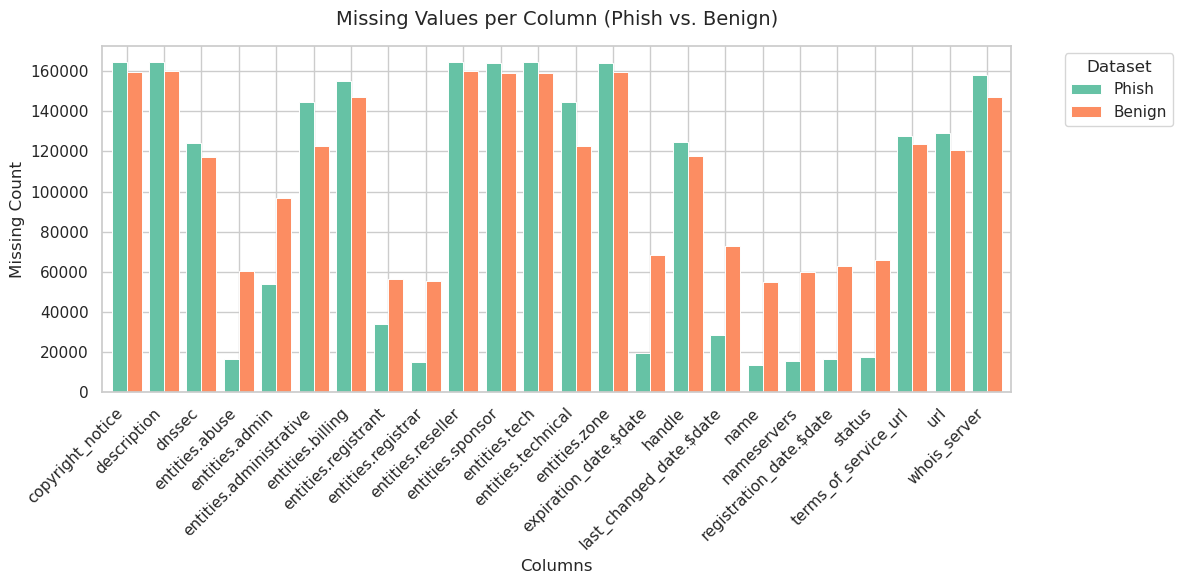

In [14]:
# Calculate the number of missing values per column in both datasets
missing_phish = phish_df.isna().sum()
missing_benign = benign_df.isna().sum()

# Combine missing counts into a single DataFrame for comparison
missing_counts = pd.DataFrame({
    'Phish': missing_phish,
    'Benign': missing_benign
})

# Keep only columns that have missing values in at least one dataset
missing_counts = missing_counts[(missing_counts['Phish'] > 0) | (missing_counts['Benign'] > 0)]

# Plot a grouped bar chart of missing value counts
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_counts.plot(
    kind='bar',
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Missing Values per Column (Phish vs. Benign)", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

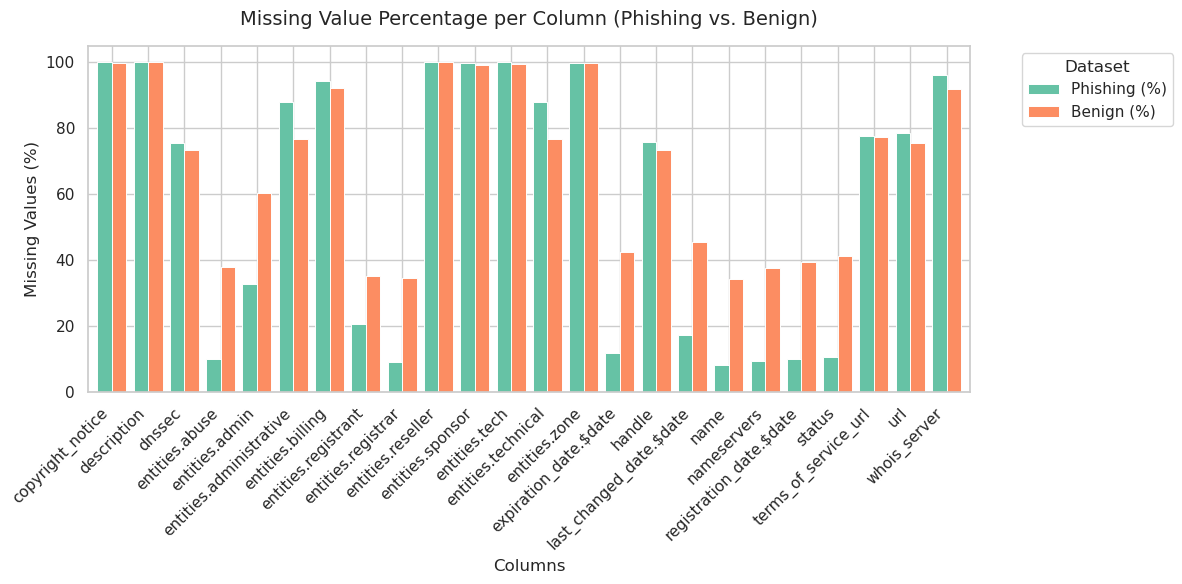

In [15]:
# Calculate missing value percentages for each column
phish_missing_pct = phish_df.isna().mean() * 100
benign_missing_pct = benign_df.isna().mean() * 100

# Combine into one DataFrame for comparison
missing_pct = pd.DataFrame({
    'Phishing (%)': phish_missing_pct,
    'Benign (%)': benign_missing_pct
})

# Keep only columns with missing values in at least one dataset
missing_pct = missing_pct[(missing_pct['Phishing (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# Plot percentage of missing values
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Missing Value Percentage per Column (Phishing vs. Benign)", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Effect Size of Missingness (Cohen's h)

To quantify the significance of missingness differences between phishing and benign datasets, Cohen's *h* is computed for each feature.  
Features with *h* < 0.2 are considered to have negligible class-based separation and are candidates for removal.


In [16]:
# Define Cohen's h effect size for difference in proportions
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Store effect sizes and missing rates per column
results = {}

for col in benign_df.columns:
    phish_missing_pct = phish_df[col].isna().mean()
    benign_missing_pct = benign_df[col].isna().mean()
    
    h_value = abs(cohens_h(phish_missing_pct, benign_missing_pct))
    
    results[col] = {
        'phish_missing_pct': phish_missing_pct,
        'benign_missing_pct': benign_missing_pct,
        "Cohen's h": h_value
    }

# Convert to DataFrame and sort by effect size
results_df = pd.DataFrame(results).T.sort_values("Cohen's h", ascending=False)

print("Cohen's h and missing percentages for each column:")
print(results_df)

# Identify features with negligible difference in missingness
threshold = 0.2  # small effect size cutoff
features_to_drop = results_df[results_df["Cohen's h"] < threshold].index.tolist()

print(f"\nFeatures recommended to drop (Cohen's h < {threshold}):")
print(features_to_drop)


Cohen's h and missing percentages for each column:
                         phish_missing_pct  benign_missing_pct  Cohen's h
status                            0.107034            0.412600   0.728501
expiration_date.$date             0.117798            0.426150   0.721873
registration_date.$date           0.100307            0.393869   0.712383
nameservers                       0.094712            0.375337   0.693152
entities.abuse                    0.099906            0.378644   0.682449
name                              0.082767            0.344244   0.670378
entities.registrar                0.091306            0.345975   0.643719
last_changed_date.$date           0.173331            0.454956   0.621775
entities.admin                    0.328119            0.604906   0.562303
entities.registrant               0.206441            0.353919   0.331008
entities.administrative           0.880158            0.767275   0.299825
entities.technical                0.880286            0.76820

In [18]:
from scipy.stats import chi2_contingency

# Safely determine whether a value is considered missing
def is_missing(x):
    """
    Returns 1 if the value is considered missing:
    - Empty list or array
    - Empty string
    - NaN (scalar)
    Otherwise returns 0.
    """
    if isinstance(x, (list, np.ndarray)):
        return int(len(x) == 0)
    elif isinstance(x, str):
        return int(x.strip() == "")
    elif pd.isna(x):
        return 1
    else:
        return 0

# Label the datasets
benign_df['label'] = 0
phish_df['label'] = 1

# Combine for unified analysis
df = pd.concat([benign_df, phish_df], ignore_index=True)
print("Combined dataframe shape:", df.shape)

# Manually specified RDAP fields to evaluate
cols_to_check = [
    'handle', 'name', 'whois_server', 'terms_of_service_url', 'copyright_notice',
    'description', 'last_changed_date.$date', 'registration_date.$date',
    'expiration_date.$date', 'url', 'entities.registrant', 'entities.abuse',
    'entities.admin', 'entities.registrar', 'nameservers', 'status',
    'entities.technical', 'entities.administrative', 'entities.billing',
    'dnssec', 'entities.sponsor', 'entities.zone', 'entities.tech', 'entities.reseller'
]

missing_stats = {}

# Perform missingness test per column
for col in cols_to_check:
    if col in df.columns:
        indicator = df[col].apply(is_missing)
        overall_missing_rate = indicator.mean()
        contingency = pd.crosstab(indicator, df['label'])

        # Only test if both classes are present
        p_value = chi2_contingency(contingency)[1] if contingency.shape[1] == 2 else 1.0

        missing_stats[col] = {
            'overall_missing_rate': overall_missing_rate,
            'chi2_p_value': p_value,
            'contingency_table': contingency
        }

        print(f"Column: {col}")
        print(f"  Overall Missing Rate: {overall_missing_rate:.2f}")
        print(f"  Chi-Square p-value: {p_value:.4f}")
        print(f"  Contingency Table:\n{contingency}\n")

# Filter out columns that are both highly missing and not significantly class-correlated
columns_to_drop = [
    col for col, stats in missing_stats.items()
    if stats['overall_missing_rate'] > 0.90 and stats['chi2_p_value'] > 0.05
]

print("\nFinal list of columns to drop based on missingness and statistical test:")
print(columns_to_drop)


Combined dataframe shape: (324425, 26)
Column: handle
  Overall Missing Rate: 0.75
  Chi-Square p-value: 0.0000
  Contingency Table:
label        0       1
handle                
0        42461   39924
1       117539  124501

Column: name
  Overall Missing Rate: 0.21
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
name                 
0      104921  150816
1       55079   13609

Column: whois_server
  Overall Missing Rate: 0.94
  Chi-Square p-value: 0.0000
  Contingency Table:
label              0       1
whois_server                
0              12883    6180
1             147117  158245

Column: terms_of_service_url
  Overall Missing Rate: 0.77
  Chi-Square p-value: 0.0026
  Contingency Table:
label                      0       1
terms_of_service_url                
0                      36409   36689
1                     123591  127736

Column: copyright_notice
  Overall Missing Rate: 1.00
  Chi-Square p-value: 0.0000
  Contingency Table:
label          

In [19]:
# Drop features with excessive missingness (>70%) in either dataset

missing_threshold = 0.70

# Calculate missingness rates
phish_missing_pct = phish_df.isna().mean()
benign_missing_pct = benign_df.isna().mean()

# Identify features that exceed the threshold in either class
phish_high_missing = phish_missing_pct[phish_missing_pct > missing_threshold].index
benign_high_missing = benign_missing_pct[benign_missing_pct > missing_threshold].index

# Union of all features that violate the threshold
features_high_missing = set(phish_high_missing).union(benign_high_missing)

print("Features with missingness > 70% in at least one dataset:")
print(features_high_missing)


Features with missingness > 70% in at least one dataset:
{'whois_server', 'entities.technical', 'dnssec', 'entities.billing', 'entities.administrative', 'entities.sponsor', 'entities.tech', 'description', 'terms_of_service_url', 'copyright_notice', 'entities.reseller', 'url', 'entities.zone', 'handle'}


### Inspection of columns which should be dropped according to statistical analysis

In [20]:
# Manually inspect high-missing features before dropping them

for col in features_high_missing:
    print(f"Column: {col}")
    print("Benign value counts:")
    print(benign_df[col].value_counts(dropna=False))
    print("\nPhishing value counts:")
    print(phish_df[col].value_counts(dropna=False))
    print("-" * 70)


Column: whois_server
Benign value counts:
whois_server
NaN                      147117
whois.nic.uk               1614
whois.id                   1152
whois.ca.fury.ca            697
whois.ovh.com               670
                          ...  
whois.serveisweb.com          1
whois.nic.scot                1
whois.netearthone.com         1
whois.porkbun.com             1
whois.instra.com              1
Name: count, Length: 240, dtype: int64

Phishing value counts:
whois_server
NaN                      158245
whois.nic.xyz              1314
whois.nic.br                834
whois.nic.online            589
whois.nic.top               531
                          ...  
whois.nic.motorcycles         1
whois.name.com                1
whois.nic.london              1
whois.systonic.fr             1
whois.nic.kred                1
Name: count, Length: 85, dtype: int64
----------------------------------------------------------------------
Column: entities.technical
Benign value counts:
entities

In [21]:
# Inspect the 'description' field in benign dataset
print("Unique values in benign 'description':")
print(benign_df["description"].explode().dropna().unique())

# Inspect frequency of 'copyright_notice' values in both datasets
print("\nPhishing 'copyright_notice' value counts:")
print(phish_df["copyright_notice"].explode().dropna().value_counts())

print("\nBenign 'copyright_notice' value counts:")
print(benign_df["copyright_notice"].explode().dropna().value_counts())


Unique values in benign 'description':
['This is a public suffix'
 'The TLD is not associated with, or sponsored by, any national or international government agency or branch of the armed forces in any nation.']

Phishing 'copyright_notice' value counts:
copyright_notice
Auteursrechtvoorbehoud: Niets uit deze publicatie mag zonder voorafgaande uitdrukkelijke toestemming van SIDN worden verveelvoudigd, openbaar gemaakt, worden opgeslagen in een gegevensbestand of worden overgezonden, in welke vorm dan ook, elektronisch, mechanisch, door middel van opname of anderszins. Voor registrars geldt dit voorbehoud onverkort, behoudens redelijkerwijs noodzakelijke verveelvoudigingen of openbaarmakingen ten behoeve van de werkzaamheden van registrars, zoals vermeld in de 'Algemene voorwaarden voor registrars'. Elk gebruik van deze informatie voor commerci�le of reclamedoeleinden of soortgelijke activiteiten, is expliciet verboden en tegen overtreding van dat verbod zal worden opgetreden. SIDN verz

In [22]:
# Helper to convert nested or unhashable types into comparable representations
def make_hashable(x):
    """
    Recursively convert nested structures into hashable formats for value comparison.
    - Dicts become sorted tuples of key-value pairs
    - Lists become tuples of hashable elements
    """
    if isinstance(x, dict):
        return tuple(sorted((k, make_hashable(v)) for k, v in x.items()))
    elif isinstance(x, list):
        return tuple(make_hashable(item) for item in x)
    else:
        return x

# Inspect unique structured values in candidate columns for removal
for col in columns_to_drop:
    print(f"Unique values in column '{col}':")
    exploded_values = df[col].explode().dropna().apply(make_hashable)
    print(exploded_values.value_counts(), "\n")


Unique values in column 'entities.reseller':
entities.reseller
((handle, RSR_44969-SIDN), (name, Cloud DNS Ltd), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_44969-SIDN))                 4
((handle, RSR_11129-SIDN), (name, Mijndomein Hosting BV), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_11129-SIDN))         4
((name, Cloud DNS Ltd), (type, entity))                                                                                              3
((handle, RSR_39953-SIDN), (name, Neostrada), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_39953-SIDN))                     3
((handle, NOT APPLICABLE), (name, NAMECHEAP), (type, entity))                                                                        2
((handle, RSR_37854-SIDN), (name, TransIP), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_37854-SIDN))                       2
((email, corp-gtld-transfers@cscinfo.com), (handle, LEX-N-R-5M3-1), (name, CSC Corporate Domains, Inc.), (type, entity))       

### Dropping the columns

In [23]:
# Finalize list of features to drop
columns_to_drop = list(features_high_missing) + ['name']  # 'name' assumed to be too sparse or noisy
print("Columns to drop:")
print(columns_to_drop)

# Preserve 'dnssec' for potential binary use — remove if accidentally included
if 'dnssec' in columns_to_drop:
    columns_to_drop.remove('dnssec')
    print("Updated list after keeping 'dnssec':")
    print(columns_to_drop)

# Drop columns from both datasets
benign_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
phish_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Impute missing values in 'dnssec' with 'False'
benign_df['dnssec'] = benign_df['dnssec'].fillna('False')
phish_df['dnssec'] = phish_df['dnssec'].fillna('False')

Columns to drop:
['whois_server', 'entities.technical', 'dnssec', 'entities.billing', 'entities.administrative', 'entities.sponsor', 'entities.tech', 'description', 'terms_of_service_url', 'copyright_notice', 'entities.reseller', 'url', 'entities.zone', 'handle', 'name']
Updated list after keeping 'dnssec':
['whois_server', 'entities.technical', 'entities.billing', 'entities.administrative', 'entities.sponsor', 'entities.tech', 'description', 'terms_of_service_url', 'copyright_notice', 'entities.reseller', 'url', 'entities.zone', 'handle', 'name']


In [25]:
# Preview the cleaned benign dataset
print("Benign dataset preview:")
render_dataframe(benign_df, max_rows=100, max_cols=50)

Benign dataset preview:


,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrant,entities.abuse,entities.admin,entities.registrar,nameservers,status,dnssec,label
0,00000fs3085d.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
1,0000100b00e9.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
2,0000100q012c.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
3,0000102n02c4.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
4,0000102n02d5.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
5,0000102n03d3.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
6,0000102n0434.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
7,000010560066.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
8,0000105600be.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
9,000010640021.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0


In [26]:
# Preview the cleaned phishing dataset
print("Phishing dataset preview:")
render_dataframe(phish_df, max_rows=100, max_cols=50)

Phishing dataset preview:


,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,label
0,conflrma57843.com,2024-04-27T11:19:45Z,2024-04-27T11:17:07Z,2025-04-27T11:17:07Z,"[{'handle': '1250', 'type': 'entity', 'name': 'OwnRegistrar, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['AISHA.NS.CLOUDFLARE.COM', 'ROMMY.NS.CLOUDFLARE.COM']",['active'],False,nan,nan,1
1,www.zgahdjm.com,2024-04-02T07:05:11Z,2021-04-01T06:22:41Z,2025-04-01T06:22:41Z,[{'name': 'Gname.com Pte. Ltd.'}],[{'email': ''}],"['JM1.DNS.COM', 'JM2.DNS.COM']",['client transfer prohibited'],False,[{'name': 'Redacted for privacy'}],[{'name': ''}],1
2,attt.pages.dev,2023-09-04T18:15:07Z,2020-09-02T02:33:29Z,2026-09-02T02:33:29Z,"[{'name': 'CloudFlare, Inc.'}]",[{'email': ''}],"['ADI.NS.CLOUDFLARE.COM', 'KARL.NS.CLOUDFLARE.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,[{'name': 'DATA REDACTED'}],[{'name': ''}],1
3,chermate.weeblysite.com,2022-12-19T08:40:44Z,2012-12-19T04:07:22Z,2023-12-19T04:07:22Z,[{'name': 'SafeNames Ltd.'}],[{'email': ''}],"['DNS1.P08.NSONE.NET', 'DNS2.P08.NSONE.NET', 'DNS3.P08.NSONE.NET', 'DNS4.P08.NSONE.NET']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,"[{'name': 'Weebly, Inc.'}]",[{'name': ''}],1
4,allegrolokalnie.oferta73.pl,2024-04-04T21:40:53Z,2024-03-29T22:44:41Z,nan,[{'name': 'Hosting Concepts B.V.'}],[{'email': ''}],"['NS1.DNS-SUSPENDED.COM', 'NS2.DNS-SUSPENDED.COM']",nan,False,[{'name': ''}],[{'name': ''}],1
5,validarnavegador.com,2023-10-27T01:36:15Z,2023-09-13T11:37:16Z,2024-09-13T11:37:16Z,"[{'handle': '1910', 'type': 'entity', 'name': 'CloudFlare, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['ISABEL.NS.CLOUDFLARE.COM', 'JAMES.NS.CLOUDFLARE.COM']","['client hold', 'client transfer prohibited']",False,nan,nan,1
6,contraato.salonqs.cl,nan,nan,nan,[{'name': 'nic.cl'}],[{'email': ''}],nan,nan,False,[{'name': ''}],[{'name': ''}],1
7,assets-project-cloud.reconfirmation-zip.workers.dev,2022-12-15T00:03:23Z,2019-02-08T20:36:47Z,2025-02-08T20:36:47Z,"[{'name': '101domain, Inc.'}]",[{'email': ''}],"['CLYDE.NS.CLOUDFLARE.COM', 'SOFIA.NS.CLOUDFLARE.COM']",['client transfer prohibited'],False,[{'name': ''}],[{'name': ''}],1
8,urkedxs.com,2024-03-23T11:50:51Z,2024-03-23T11:47:25Z,2025-03-23T11:47:25Z,"[{'handle': '1599', 'type': 'entity', 'name': 'Alibaba Cloud Computing Ltd. d/b/a HiChina (www.net.cn)'}]","[{'type': 'entity', 'name': '', 'email': 'DomainAbuse@service.aliyun.com'}]","['DNS29.HICHINA.COM', 'DNS30.HICHINA.COM']",['active'],False,nan,nan,1
9,faeraea.top,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,1


In [27]:
# Identify and remove rows where all feature values are missing (excluding key fields)

# Columns to evaluate (exclude domain_name, label, dnssec)
cols_to_check = [col for col in benign_df.columns if col not in ['domain_name', 'label', 'dnssec']]

# Find rows in which all these fields are missing
mask_all_nan_benign = benign_df[cols_to_check].isna().all(axis=1)
mask_all_nan_phish = phish_df[cols_to_check].isna().all(axis=1)

# Report and drop such rows
print("Empty benign rows (all NaNs across feature columns):", mask_all_nan_benign.sum())
print("Empty phishing rows (all NaNs across feature columns):", mask_all_nan_phish.sum())

benign_df.drop(index=benign_df[mask_all_nan_benign].index, inplace=True)
phish_df.drop(index=phish_df[mask_all_nan_phish].index, inplace=True)

# Final shape confirmation
print("Shapes after removing all-NaN rows:")
print("Benign:", benign_df.shape)
print("Phishing:", phish_df.shape)


Empty benign rows (all NaNs across feature columns): 55079
Empty phishing rows (all NaNs across feature columns): 13626
Shapes after removing all-NaN rows:
Benign: (104921, 12)
Phishing: (150799, 12)


In [28]:
# Inspect the distribution of RDAP status values in the benign dataset
print("Benign 'status' value counts:")
print(benign_df["status"].value_counts(dropna=False))


Benign 'status' value counts:
status
[client transfer prohibited]                                                                                        28292
[ok]                                                                                                                13120
[active]                                                                                                            12196
NaN                                                                                                                 10937
[client delete prohibited, client renew prohibited, client transfer prohibited, client update prohibited]            6115
                                                                                                                    ...  
[inactive, server transfer prohibited, server hold, pending delete, server update prohibited, redemption period]        1
[client transfer prohibited, server transfer prohibited, renew period]                                       

In [29]:
# Explore structure of nested entity fields to determine standard keys
entity_fields = ['entities.abuse', 'entities.registrar', 'entities.registrant', 'entities.admin']

for col in entity_fields:
    unique_keys = set()
    for cell in df[col]:
        if isinstance(cell, list):
            for entry in cell:
                if isinstance(entry, dict):
                    unique_keys.update(entry.keys())
    print(f"Unique keys found in '{col}': {sorted(unique_keys)}")


Unique keys found in 'entities.abuse': ['email', 'handle', 'name', 'tel', 'type', 'url']
Unique keys found in 'entities.registrar': ['email', 'handle', 'name', 'tel', 'type', 'url', 'whois_server']
Unique keys found in 'entities.registrant': ['email', 'handle', 'name', 'rir', 'tel', 'type', 'url', 'whois_server']
Unique keys found in 'entities.admin': ['email', 'handle', 'name', 'type']


In [30]:
print("Benign 'dnssec' value counts:")
print(benign_df["dnssec"].value_counts(dropna=False))


Benign 'dnssec' value counts:
dnssec
False    62370
False    39673
True      2878
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

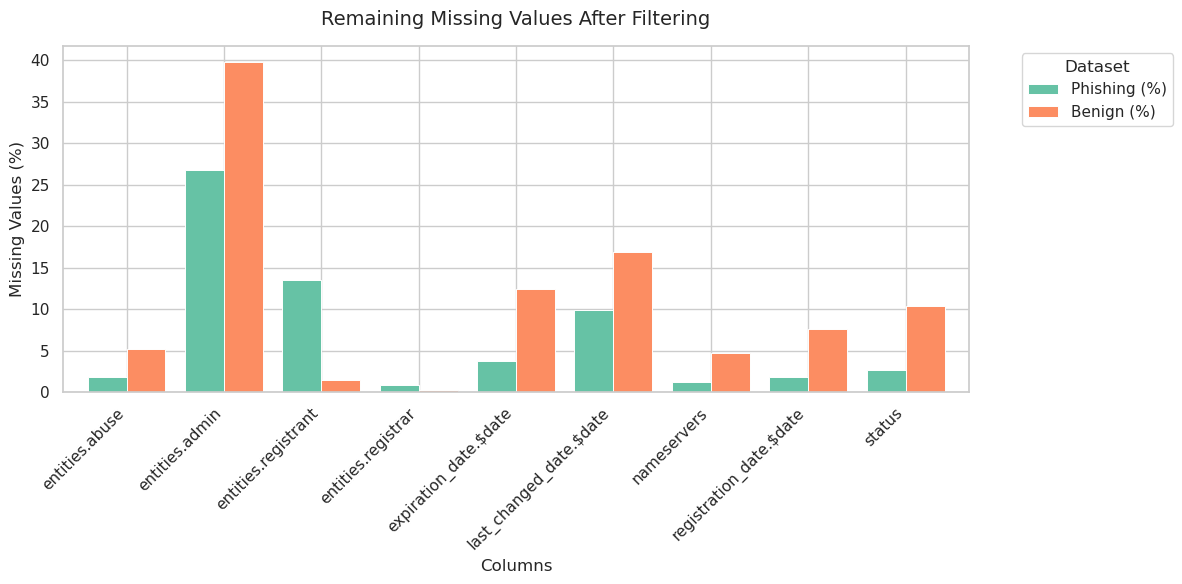

In [31]:
# Recalculate missing value percentages after filtering
phish_missing_pct = phish_df.isna().mean() * 100
benign_missing_pct = benign_df.isna().mean() * 100

# Combine into a DataFrame for side-by-side comparison
missing_pct = pd.DataFrame({
    'Phishing (%)': phish_missing_pct,
    'Benign (%)': benign_missing_pct
})

# Keep only columns with remaining missing values
missing_pct = missing_pct[(missing_pct['Phishing (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# Plot missing value percentages for cleaned datasets
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Remaining Missing Values After Filtering", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [32]:
print(phish_df["entities.abuse"].value_counts())
print(benign_df["entities.abuse"].value_counts())

entities.abuse
[{'email': ''}]                                                                                                       110435
[{'handle': 'FFBA2ECCF7E1438E9DDC9D520FE1BD1F-DONUTS', 'type': 'entity', 'email': 'abuse@support.gandi.net'}]           5801
[{'type': 'entity', 'name': '', 'email': ''}]                                                                           3128
[{'type': 'entity', 'email': 'tldsupport@cscinfo.com'}]                                                                 2844
[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]                                                          2037
                                                                                                                       ...  
[{'type': 'entity', 'name': '', 'email': 'abuse@infomaniak.com'}]                                                          1
[{'type': 'entity', 'name': 'Abuse contact', 'tel': '01225-965999', 'email': 'abuse@verpex.com'}]             

# Prepare the dataframe for trasnformer training
For training the transformer, it is neccessary to create a one concatenated string with fields from analyzed dataframe

In [33]:
def stringify_value(value):
    """
    Converts a value to string, serializing dicts to JSON.
    Returns 'NA' for missing or empty inputs.
    """
    if isinstance(value, dict):
        return json.dumps(value)
    if value in [None, '', [], {}]:
        return "NA"
    return str(value)


def format_entity_entry(entry, canonical_keys):
    """
    Formats a single entity dictionary into a standardized key-value string.
    """
    return " | ".join(
        f"{key}: {stringify_value(entry.get(key, 'NA'))}" for key in canonical_keys
    )


def process_entity_field(entity_list, canonical_keys, field_label):
    """
    Converts a list of entity dictionaries into a structured string representation.
    """
    if not entity_list or not isinstance(entity_list, list):
        return f"{field_label}: NA"
    
    formatted = [format_entity_entry(entry, canonical_keys) for entry in entity_list]
    return f"{field_label}: " + " ; ".join(formatted)


def process_list_field(values, field_label, separator=", "):
    """
    Converts a list of simple values into a delimited string.
    """
    if not values or not isinstance(values, list) or len(values) == 0:
        return f"{field_label}: NA"
    
    cleaned = [str(v).strip() for v in values if v]
    return f"{field_label}: " + separator.join(cleaned) if cleaned else f"{field_label}: NA"


def concat_rdap_fields(row):
    """
    Constructs a transformer-friendly input string from selected RDAP fields.
    """
    CLS_TOKEN = "[CLS]"
    SEP_TOKEN = "[SEP]"
    
    tokens = []

    domain = row.get("domain_name", "NA").lower().lstrip("www.")
    tokens.append(f"domain: {domain}")

    abuse_keys      = ['name', 'type', 'email', 'url', 'tel', 'handle']
    registrar_keys  = ['name', 'email', 'whois_server', 'url', 'tel', 'handle', 'type']
    registrant_keys = ['name', 'email', 'whois_server', 'url', 'rir', 'tel', 'handle', 'type']
    admin_keys      = ['name', 'email', 'handle', 'type']

    tokens.append(process_entity_field(row.get("entities.abuse", []), abuse_keys, "abuse"))
    tokens.append(process_entity_field(row.get("entities.registrar", []), registrar_keys, "registrar"))
    tokens.append(process_entity_field(row.get("entities.registrant", []), registrant_keys, "registrant"))
    tokens.append(process_entity_field(row.get("entities.admin", []), admin_keys, "admin"))

    tokens.append(process_list_field(row.get("nameservers", []), "nameservers"))
    tokens.append(process_list_field(row.get("status", []), "status"))

    return f"{CLS_TOKEN} " + f" {SEP_TOKEN} ".join(tokens) + f" {SEP_TOKEN}"


In [34]:
benign_df['input_string'] = benign_df.apply(concat_rdap_fields, axis=1)
phish_df['input_string'] = phish_df.apply(concat_rdap_fields, axis=1)

combined_df = pd.concat(
    [benign_df[['input_string', 'label']], phish_df[['input_string', 'label']]],
    ignore_index=True
)

combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

render_dataframe(combined_df)


,input_string,label
0,"[CLS] domain: instagraamloginn.blogspot.com [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: MarkMonitor Inc. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: Google LLC | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS1.GOOGLE.COM, NS2.GOOGLE.COM, NS3.GOOGLE.COM, NS4.GOOGLE.COM [SEP] status: client delete prohibited, client transfer prohibited, client update prohibited, server delete prohibited, server transfer prohibited, server update prohibited [SEP]",1
1,"[CLS] domain: cuevana3.promo [SEP] abuse: name: NA | type: entity | email: abuse@namecheap.com | url: NA | tel: NA | handle: 10AF0F41201E4614A3B8939BABA4BDF2-DONUTS [SEP] registrar: name: NameCheap, Inc. | email: NA | whois_server: NA | url: https://rdap.donuts.co/rdap/entity/1068 | tel: NA | handle: 1068 | type: entity [SEP] registrant: name: Privacy service provided by Withheld for Privacy ehf | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: entity [SEP] admin: NA [SEP] nameservers: kay.ns.cloudflare.com, kanye.ns.cloudflare.com [SEP] status: client transfer prohibited [SEP]",0
2,"[CLS] domain: majoranaiiss.edu.it [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Aruba s.p.a. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: I.I.S.S. E.Majorana | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: DNS.TECHNORAIL.COM, DNS2.TECHNORAIL.COM, DNS3.ARUBADNS.NET, DNS4.ARUBADNS.CZ [SEP] status: ok [SEP]",0
3,"[CLS] domain: rbmoto.lv [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: NA | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS1.AREAIT.LV, NS2.AREAIT.LV [SEP] status: active [SEP]",0
4,"[CLS] domain: co.jp-admin.xrwcma.cn [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: 阿里云计算有限公司（万网） | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: 陆惠普 | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: DNS29.HICHINA.COM, DNS30.HICHINA.COM [SEP] status: ok [SEP]",1
5,"[CLS] domain: blade2.vienna-rack412.nodes.gen4.ninja [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Gandi SAS | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: CyberGhost SA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS1.GEN4.NINJA, NS2.GEN4.NINJA, NS3.GEN4.NINJA [SEP] status: client transfer prohibited [SEP]",0
6,"[CLS] domain: bellsouthverification-cf9bf2.webflow.io [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: MarkMonitor Inc. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: Webflow, Inc | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS-135.AWSDNS-16.COM, NS-1481.AWSDNS-57.ORG, NS-1541.AWSDNS-00.CO.UK, NS-828.AWSDNS-39.NET [SEP] status: client delete prohibited, client transfer prohibited, client update prohibited [SEP]",1
7,"[CLS] domain: nnfjc.

In [32]:
# combined_df.info()
# save_path = project_root / "datasets" / "phishing" / "rdap_phishing_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)
